# This is a PINN (Physics-Informed Neural Network) model, that computes the solution of a differential equation using the DeepXDE library:
$$y'' - y' - y = 2x, x∈[-5,5]$$

$$y(-5) = 1, y(5) = 5$$

**Details:**

* Layer schema: [1, 60, 60, 1]

* Activation function: Tanh

* num_domain: 3000,  num_test: 100

* Test loss for 7000 epochs:  [6.51e-04, 3.20e-07, 2.69e-06] 

In [ ]:
# Importing libraries
  
!pip install deepxde
import deepxde as dde
import tensorflow as tf
import numpy as np

     |████████████████████████████████| 121 kB 4.9 MB/s 
     |████████████████████████████████| 100 kB 10.1 MB/s 


Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [ ]:
# Define computational geometry

geom = dde.geometry.Interval(-5, 5)

In [ ]:
# Define the differential equation

def ode(x, y):
    dy_xx = dde.grad.hessian(y, x)
    dy_x = dde.grad.jacobian(y, x)
    return dy_xx - dy_x - y -2*x

In [ ]:
# Define the boundary conditions

def boundary_1(x, _):
    return np.isclose(x[0], -5)

def boundary_2(x, _):
    return np.isclose(x[0], 5)

bc_1 = dde.icbc.DirichletBC(geom, lambda x: 1, boundary_1)
bc_2 = dde.icbc.DirichletBC(geom, lambda x: 5, boundary_2)

In [ ]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, ode, [bc_1, bc_2], num_domain=3000, num_boundary=2, num_test=100)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+3002=3002. 
  total_n_samples))


In [ ]:
# Create the neural network

layer_size = [1, 60, 60, 60, 1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
# Build and train the model

model = dde.Model(data, net)
model.compile("adam", lr=0.0005)

losshistory, train_state = model.train(epochs=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.200030 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 1.098624 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.85e+01, 2.36e-01, 3.04e+01]    [2.79e+01, 2.36e-01, 3.04e+01]    []  
1000      [1.96e-02, 4.46e-07, 1.99e-04]    [1.41e-02, 4.46e-07, 1.99e-04]    []  
2000      [4.47e-03, 4.12e-08, 6.85e-06]    [3.55e-03, 4.12e-08, 6.85e-06]    []  
3000      [1.71e-03, 2.83e-06, 7.34e-05]    [1.24e-03, 2.83e-06, 7.34e-05]    []  
4000      [9.34e-04, 1.49e-09, 1.88e-06]    [6.14e-04, 1.49e-09, 1.88e-06]    []  
5000      [5.87e-04, 1.77e-08, 1.37e-07]    [3.42e-04, 1.77e-08, 1.37e-07]    []  
6000      [3.97e-04, 7.05e-09, 1.78e-07]    [1.98e-04, 7.05e-09, 1.78e-07]    []  
7000      [3.78e-04, 1.14e-05, 2.69e-04]    [1.79e-04, 1.14e-05, 2.69e-04]    []  
8000      [3.67e-04, 6.60e-06, 1.03e-04]    [2.00e-04, 6.60e-06, 1.03e-04]    []  
9000      [2.59e-04, 1.35e-06, 3.04e-05]    [1.21e-04, 1.35e-06, 3.04e-05]    []  
10000   

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


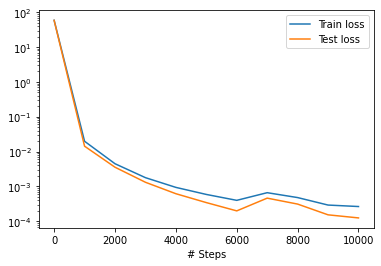

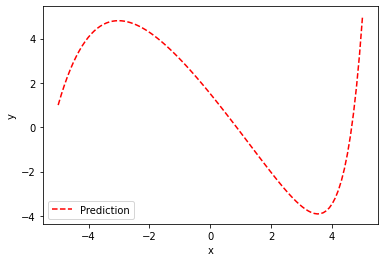

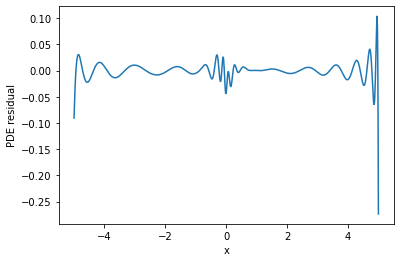

In [ ]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=ode)

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()